In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    document.body.style.fontFamily='Helvetica Neue';
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Consolas';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Probabilistic Programming and Bayesian Methods for Hackers Chapter  2
---
### Table of Contents

- Dependencies & Prerequisites
- A little more on TFP
  - TFP Variables
    - Initializing Stochastic Variables
    - Deterministic variables
  - Combining with Tensorflow Core
  - Including observations in the Model
- Modeling approaches
  - Same story; different ending
  - Example: Bayesian A/B testing
  - A Simple Case
    - Execute the TF graph to sample from the posterior
  - A and B together
    - Execute the TF graph to sample from the posterior
- An algorithm for human deceit
  - The Binomial Distribution
  - Example: Cheating among students
    - Execute the TF graph to sample from the posterior
  - Alternative TFP Model
    - Execute the TF graph to sample from the posterior
  - More TFP Tricks
  - Example: Challenger Space Shuttle Disaster
    - Normal Distributions
      - Execute the TF graph to sample from the posterior
    - What about the day of the Challenger disaster?
    - Is our model appropriate?
      - Execute the TF graph to sample from the posterior
  - Exercises
  - References
___

This chapter introduces more TFP syntax and variables and ways to think about how to model a system from a Bayesian perspective. It also contains tips and data visualization techniques for assessing goodness-of-fit for your Bayesian model.

In [2]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass


from __future__ import absolute_import, division, print_function


#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from '/Users/sliu/Tutorials/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/venv/lib/python3.8/site-packages/tensorflow/_api/v2/config/__init__.py'>

### TFP Distributions

Let's look into how [`tfp.distributions`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions) work.

TFP uses distribution subclasses to represent *stochastic*, random variables. A variable is stochastic when the following is true: even if you knew all the values of the variable's parameters and components, it would still be random. Included in this category are instances of classes [`Poisson`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Poisson), [`Uniform`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Uniform), and [`Exponential`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Exponential).

You can draw random samples from a stochastic variable. When you draw samples, those samples become [`tensorflow.Tensors`](https://www.tensorflow.org/api_docs/python/tf/Tensor) that behave deterministically from that point on. A quick mental check to determine if something is *deterministic* is: *If I knew all of the inputs for creating the variable `foo`, I could calculate the value of `foo`.*  You can add, subtract, and otherwise manipulate the tensors in a variety of ways discussed below. These operations are almost always deterministic.

#### Initializing a Distribution

Initializing a stochastic, or random, variable requires a few class-specific parameters that describe the Distribution's shape, such as the location and scale. For example:

```python
some_distribution = tfd.Uniform(0., 4.)
```

initializes a stochastic, or random, [`Uniform`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Uniform) distribution with the lower bound at 0 and upper bound at 4. Calling `sample()` on the distribution returns a tensor that will behave deterministically from that point on:

```python
sampled_tensor = some_distribution.sample()
```

The next example demonstrates what we mean when we say that distributions are stochastic but tensors are deterministic:

```
derived_tensor_1 = 1 + sampled_tensor
derived_tensor_2 = 1 + sampled_tensor  # equal to 1

derived_tensor_3 = 1 + some_distribution.sample()
derived_tensor_4 = 1 + some_distribution.sample()  # different from 3
```

The first two lines produce the same value because they refer to the same sampled tensor. The last two lines likely produce different values because they refer to independent samples drawn from the same distribution.

To define a multiviariate distribution, just pass in arguments with the shape you want the output to be when creating the distribution. For example:

```python
betas = tfd.Uniform([0., 0.], [1., 1.])
```

Creates a Distribution with batch_shape (2,). Now, when you call betas.sample(),
two values will be returned instead of one. You can read more about TFP shape semantics in the [TFP docs](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb), but most uses in this book should be self-explanatory.

#### Deterministic variables

We can create a deterministic distribution similarly to how we create a stochastic distribution. We simply call up the [`Deterministic`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Deterministic) class from Tensorflow Distributions and pass in the deterministic value that we desire
```python
deterministic_variable = tfd.Deterministic(name="deterministic_variable", loc=some_function_of_variables)
```

Calling `tfd.Deterministic` is useful for creating distributions that always have the same value. However, the much more common pattern for working with deterministic variables in TFP is to create a tensor or sample from a distribution:

In [3]:
lambda_1 = tfd.Exponential(rate=1., name='lambda_1') # stochastic variable
lambda_2 = tfd.Exponential(rate=1., name='lambda_2') # stochastic variable
tau = tfd.Uniform(name='tau', low=0., high=10.) # stochastic variable

# deterministic variable since we are getting results of lambda's after sampling
new_deterministic_variable = tfd.Deterministic(name='deterministic_variable',
                                               loc=(lambda_1.sample() + lambda_2.sample()))

2021-09-06 14:12:02.777627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The use of the deterministic variable was seen in the previous chapter's text-message example.  Recall the model for $\lambda$ looked like: 

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

And in TFP code:

In [4]:
tf.cast?

In [5]:
# days
n_data_points = 5
idx = np.arange(n_data_points)

# for n_data_points samples, select from lambda_2 if sampled tau >= day value, lambda_1 otherwise
rv_lambda_deterministic = tfd.Deterministic(tf.gather([lambda_1.sample(), lambda_2.sample()],
                                                     indices=tf.cast(tau.sample() >= idx, dtype=tf.int32)))
lambda_deterministic = rv_lambda_deterministic.sample()

In [6]:
print(f"{n_data_points} samples from our deterministic lambda model: \n", lambda_deterministic.numpy())

5 samples from our deterministic lambda model: 
 [0.02445154 0.02445154 0.02445154 0.02445154 1.480262  ]


Clearly, if $\tau, \lambda_1$ and $\lambda_2$ are known, then $\lambda$ is known completely, hence it is a deterministic variable. We use indexing here to switch from $\lambda_1$ to $\lambda_2$ at the appropriate time. 

### Including observations in the model

At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like "What does my prior distribution of $\lambda_1$ look like?" 

To do this, we will sample from the distribution. The method `.sample()` has a very simple role: get data points from the given distribution. We can then evaluate the resulting tensor to get a NumPy array-like object. 

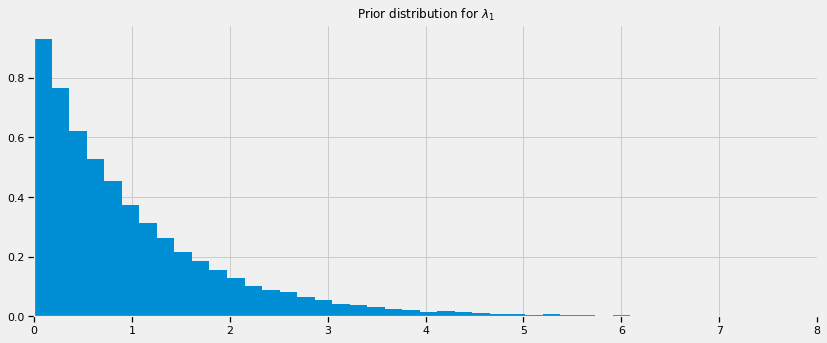

In [7]:
# Define our observed samples
rv_lambda_1 = tfd.Exponential(rate=1., name='lambda_1')
lambda_1 = rv_lambda_1.sample(sample_shape=20000)

# Visualize our stepwise prior distribution
plt.subplots(figsize=(12.5, 5))
plt.hist(lambda_1.numpy(), bins=70, density=True, histtype='stepfilled')
plt.title(r"Prior distribution for $\lambda_1$")
plt.xlim(0, 8);

To frame this in the notation of the first chapter, though this is a slight abuse of notation, we have specified $P(A)$. Our next goal is to include data/evidence/observations $X$ into our model. 

Sometimes we may want to match a property of our distribution to a property of observed data. To do so, we get the parameters for our distribution fom the data itself. In this example, the Poisson rate (average number of events) is explicitly set to one over the average of the data:

In [8]:
data = tf.constant([10., 5.], dtype=tf.float32)
rv_poisson = tfd.Poisson(rate=1./tf.reduce_mean(data))
poisson = rv_poisson.sample()

# Show results
print("two predetermined data points: ", data)
print("\n mean of our data: ", np.mean(data))
print("\n random sample from Poisson distribution with the same as the poisson rate: \n", poisson.numpy())

two predetermined data points:  tf.Tensor([10.  5.], shape=(2,), dtype=float32)

 mean of our data:  7.5

 random sample from Poisson distribution with the same as the poisson rate: 
 0.0


2021-09-06 14:12:03.440008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-06 14:12:03.478236: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1652] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


## Modeling approaches

A good starting thought to Bayesian modeling is to think about *how your data might have been generated*. Position yourself in an omniscient position, and try to imagine how *you* would recreate the dataset. 

In the last chapter we investigated text message data. We begin by asking how our observations may have been generated:

1.  We started by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of sms's received as sampled from a Poisson distribution.

2.  Next, we think, "Ok, assuming sms's are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$. 

3.  Do we know $\lambda$? No. In fact, we have a suspicion that there are *two* $\lambda$ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.

5.  Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 10 and 30", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. 

    What is a good value for $\alpha$ then? We think that the $\lambda$s are between 10-30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. This was shown in the last chapter.

6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.


Below we give a graphical visualization of this, where arrows denote `parent-child` relationships. (provided by the [Daft Python library](http://daft-pgm.org/) )

<img src="http://i.imgur.com/7J30oCG.png">


TFP and other probabilistic programming languages have been designed to tell these data-generation *stories*. More generally, B. Cronin writes [2]:

> Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options.

### Same story; different ending.

Interestingly, we can create *new datasets* by retelling the story.
For example, if we reverse the above steps, we can simulate a possible realization of the dataset.

1\. Specify when the user's behaviour switches by sampling from $\text{DiscreteUniform}(0, 80)$:

In [9]:
tau = tf.random.uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32).numpy()

print("Value of Tau (randomly taken from DiscreteUniform(0, 80)):", tau)

Value of Tau (randomly taken from DiscreteUniform(0, 80)): [45]


2\. Draw $\lambda_1$ and $\lambda_2$ from a $\text{Gamma}(\alpha)$ distribution:

Note: A gamma distribution is a generalization of the exponential distribution. A gamma distribution with shape parameter $\alpha = 1$ and scale parameter $\beta$ is an  exponential ($\beta$) distribution. Here, we use a gamma distribution to have more flexibility than we would have had were we to model with an exponential. Rather than returning values between $0$ and $1$, we can return values much larger than $1$ (i.e., the kinds of numbers one would expect to show up in a daily SMS count).

In [10]:
alpha = 1./8

lambda_1, lambda_2 = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2]).numpy()
print("Lambda 1 (randomly taken from Gamma(α) distribution): ", lambda_1)
print("Lambda 2 (randomly taken from Gamma(α) distribution): ", lambda_2)

Lambda 1 (randomly taken from Gamma(α) distribution):  25.408363
Lambda 2 (randomly taken from Gamma(α) distribution):  11.133369


3\.  For days before $\tau$, represent the user's received SMS count by sampling from $\text{Poi}(\lambda_1)$, and sample from  $\text{Poi}(\lambda_2)$ for days after $\tau$. For example:

In [11]:
data = tf.concat([tfd.Poisson(rate=lambda_1).sample(sample_shape=tau),
                 tfd.Poisson(rate=lambda_2).sample(sample_shape=(80 - tau))], axis=0).numpy()
days_range = tf.range(80).numpy()
print("Artificial day-by-day user SMS count created by sampling: \n", data)

Artificial day-by-day user SMS count created by sampling: 
 [37. 22. 22. 23. 21. 33. 31. 24. 23. 23. 26. 25. 25. 24. 31. 26. 21. 22.
 22. 24. 24. 15. 26. 32. 25. 22. 22. 19. 19. 28. 32. 23. 20. 22. 15. 26.
 23. 26. 23. 35. 26. 17. 30. 36. 20. 11. 15. 10. 13.  9.  5.  7. 15. 13.
 13.  9.  8. 15. 11. 13. 13. 13. 12. 12. 13. 11. 10. 10.  8. 10. 10. 14.
 11.  6. 11. 12. 14. 10. 15.  8.]


4. Plot the artifical dataset:

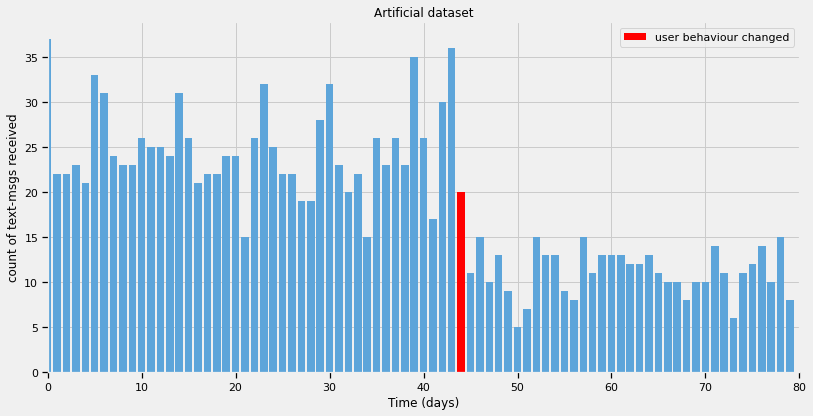

In [12]:
plt.subplots(figsize=(12, 6))
plt.bar(days_range, data, color=TFColor[3])
plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

It is okay that our fictional dataset does not look like our observed dataset: the probability is incredibly small it indeed would. TFP's engine is designed to find good parameters, $\lambda_i, \tau$, that maximize this probability.  


The ability to generate an artificial dataset is an interesting side effect of our modeling, and we will see that this ability is a very important method of Bayesian inference. We produce a few more datasets below:

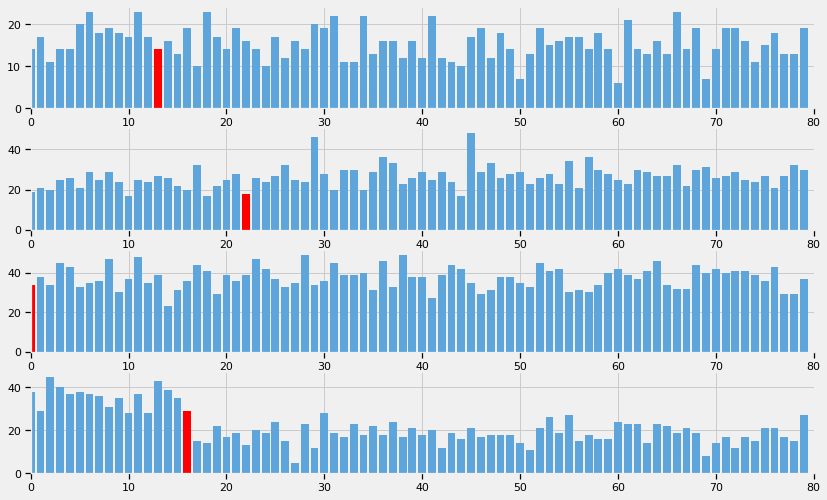

In [13]:
def plot_artificial_sms_dataset():
    tau = tf.random.uniform(shape=[1], minval=0, maxval=80, dtype=tf.int32).numpy()
    alpha = 1./8
    lambda_1, lambda_2 = tfd.Gamma(concentration=1/alpha, rate=0.3).sample(sample_shape=[2]).numpy()
    data = tf.concat([tfd.Poisson(rate=lambda_1).sample(sample_shape=tau),
                      tfd.Poisson(rate=lambda_2).sample(sample_shape=(80-tau))], axis=0).numpy()
    days_range = tf.range(80).numpy()
    
    plt.bar(days_range, data, color=TFColor[3])
    plt.bar(tau - 1, data[tau-1], color='r', label='user behaviour changed')
    plt.xlim(0, 80);
    
plt.figure(figsize=(12.5, 8))
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

Later we will see how we use this to make predictions and test the appropriateness of our models.

### Example: Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily *learned* this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural. 

### A Simple Case

As this is a hacker book, we'll continue with the web-dev example. For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To setup a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over $[0,1]$:

In [14]:
# The parameters are the bounds of the Uniform
rv_p = tfd.Uniform(low=0., high=1., name='p')

Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data. We can assume then that we can use the following generative model:

$$\begin{align*}
p &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i &= 1\ldots N:\text{# Users}  \\
 X_i\ &\sim \text{Bernoulli}(p_i)
\end{align*}$$

In [15]:
# set constants
prob_true = 0.05 # remember, this is unknown.
N = 15000

# sample N Bernoulli random variables from Ber(0.05)
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step

occurrences = tfd.Bernoulli(probs=prob_true).sample(sample_shape=N, seed=10)
occurrences_sum = tf.reduce_sum(occurrences).numpy()
occurrences_mean = tf.reduce_mean(tf.cast(occurrences, tf.float32)).numpy()

print("Array of {} Occurences:".format(N), occurrences.numpy()) 
print("(Remember: Python treats True == 1, and False == 0)")
print("Sum of (True == 1) Occurences:", occurrences_sum)

Array of 15000 Occurences: [0 0 0 ... 0 0 1]
(Remember: Python treats True == 1, and False == 0)
Sum of (True == 1) Occurences: 751


The observed frequency is:

In [16]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % occurrences_mean)
print("Does this equal the true frequency? %s" % (occurrences_mean == prob_true))

What is the observed frequency in Group A? 0.0501
Does this equal the true frequency? False


We can combine our Bernoulli distribution and our observed occurrences into a log probability function based on the two.

In [17]:
def joint_log_prob(occurrences, prob_A):
    """
    Joint log probability optimization function.
    """
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_occurrences = tfd.Bernoulli(probs=prob_A)
    return rv_prob_A.log_prob(prob_A) + tf.reduce_sum(rv_occurrences.log_prob(occurrences))

The goal of probabilistic inference is to find model parameters that may explain
data you have observed. TFP performs probabilistic inference by evaluating the
model parameters using a `joint_log_prob` function.  The arguments to `joint_log_prob` are data and model parameters—for the model defined in the `joint_log_prob` function itself. The function returns the log of the joint probability that the model parameterized as such generated the observed data per the input arguments.

All `joint_log_prob` functions have a common structure:

1. The function takes a set of **inputs** to evaluate. Each input is either an
observed value or a model parameter.

1. The `joint_log_prob` function uses probability distributions to define a **model** for evaluating the inputs. These distributions measure the likelihood of the input values. (By convention, the distribution that measures the likelihood of the variable `foo` will be named `rv_foo` to note that it is a random variable.) We use two types of distributions in `joint_log_prob` functions:

  a. **Prior distributions** measure the likelihood of input values.
A prior distribution never depends on an input value. Each prior distribution measures the
likelihood of a single input value. Each unknown variable—one that has not been
observed directly—needs a corresponding prior. Beliefs about which values could
be reasonable determine the prior distribution. Choosing a prior can be tricky,
so we will cover it in depth in Chapter 6.

  b. **Conditional distributions** measure the likelihood of an input value given
other input values. Typically, the conditional
distributions return the likelihood of observed data given the current guess of parameters in the model, p(observed_data | model_parameters).

1. Finally, we calculate and return the **joint log probability** of the inputs.
The joint log probability is the sum of the log probabilities from all of the
prior and conditional distributions. (We take the sum of log probabilities
instead of multiplying the probabilities directly for reasons of numerical
stability: floating point numbers in computers cannot represent the very small
values necessary to calculate the joint log probability unless they are in 
log space.) The sum of probabilities is actually an unnormalized density; although the total sum of probabilities  over all possible inputs might not sum to one, the sum of probabilities is proportional to the true probability density. This proportional distribution is sufficient to estimate the distribution of likely inputs.

Let's map these terms onto the code above. In this example, the input values
are the observed values in `occurrences` and the unknown value for `prob_A`. The `joint_log_prob` takes the current guess for `prob_A`
and answers, how likely is the data if `prob_A` is the probability of
`occurrences`. The answer depends on two distributions:
1. The prior distribution, `rv_prob_A`, indicates how likely the current value of `prob_A` is by itself.
2. The conditional distribution, `rv_occurrences`, indicates the likelihood of `occurrences` if `prob_A` were the  probability for the Bernoulli distribution.

The sum of the log of these probabilities is the
joint log probability. 

The `joint_log_prob` is particularly useful in conjunction with the [`tfp.mcmc`](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc)
module. Markov chain Monte Carlo (MCMC) algorithms proceed by making educated guesses about the unknown
input values and
computing what the likelihood of this set of arguments is. (We’ll talk about how it makes those guesses in Chapter 3.) By repeating this process
many times, MCMC builds a distribution of likely parameters. Constructing this
distribution is the goal of probabilistic inference.

In [18]:
number_of_steps = 48000
burnin = 25000
leapfrog_steps=2

# Set the chain's start state.
initial_chain_state =[
    tf.reduce_mean(tf.cast(occurrences, tf.float32)) * tf.ones([], dtype=tf.float32, name='init_prob_A')
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [tfp.bijectors.Identity()]

# Define a closure over our joint_log_prob
# The closure makes it so the HMC doesn't try to change the `occurrences` but
# instead determines the distributions of other parameters that might generate
# the `occurrences` we observed.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(occurrences, *args)

### Specify the posterior sampler

In [19]:
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

step_size = 0.2

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=leapfrog_steps,
        step_size=step_size,
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=hmc,
                                          num_adaptation_steps=int(burnin * 0.8))

[
    posterior_prob_A
], kernel_results = graph_sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=kernel)

In [20]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted, dtype=tf.float32))))

burned_prob_A_trace_ = posterior_prob_A[burnin:].numpy()

acceptance rate: 0.6110000014305115


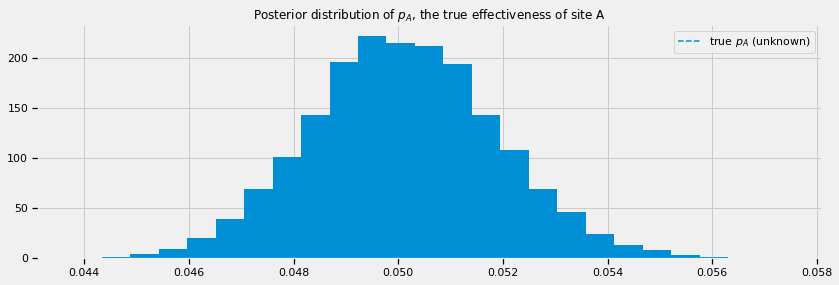

In [21]:
plt.figure(figsize(12.5, 4))
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(prob_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_prob_A_trace_, bins=25, histtype="stepfilled", density=True)
plt.legend();

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.

### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using TFP's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data ). Our model now looks like the following:

$$\begin{align*}
p_A &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
p_B &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
X\ &\sim \text{Bernoulli}(\text{prob}=p) \\
\text{for }  i &= 1\ldots N: \\
 X_i\ &\sim \text{Bernoulli}(p_i)
\end{align*}$$

In [22]:
# These two quantities are unknown to us.
true_prob_A_ = 0.05
true_prob_B_ = 0.04

# Notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A_ = 1500
N_B_ = 750

# Generate some observations
observations_A = tfd.Bernoulli(name='obs_A', probs=true_prob_A_).sample(sample_shape=N_A_, seed=42)
observations_B = tfd.Bernoulli(name='obs_B', probs=true_prob_B_).sample(sample_shape=N_B_, seed=42)

observations_A_ = observations_A.numpy()
observations_B_ = observations_B.numpy()

print("Obs from Site A: ", observations_A_[:30], "...")
print("Observed Prob_A: ", np.mean(observations_A_), "...")
print("Obs from Site B: ", observations_B_[:30], "...")
print("Observed Prob_B: ", np.mean(observations_B_))

Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_A:  0.05733333333333333 ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed Prob_B:  0.036


Below we run inference over the new model:

In [23]:
def delta(prob_A, prob_B):
    """
    Defining the deterministic delta function. This is our unknown of interest.
    
    Parameters
    ----------
    prob_A: float
        Scalar estimate of the probability of a 1 appearing in observation set A
    prob_B: float
        Scalar estimate of the probability of a 1 appearing in observation set B
        
    Returns
    -------
        Difference between prob_A and prob_B
    """
    return prob_A - prob_B


def double_joint_log_prob(observations_A, observations_B, prob_A, prob_B):
    """
    Joing log probability optimisation function.
    
    Parameters
    ----------
    observations_A: np.array
        An array of binary values representing the set of observations for site A
    observations_B: np.array
        An array of binary values representing the set of observations for site B 
      prob_A: float
          scalar estimate of the probability of a 1 appearing in observation set A
      prob_B: float
          scalar estimate of the probability of a 1 appearing in observation set B
          
    Returns
    -------
        Joint log probability optimization function.
    """
    rv_prob_A = tfd.Uniform(low=0., high=1.)
    rv_prob_B = tfd.Uniform(low=0., high=1.)
    
    rv_obs_A = tfd.Bernoulli(probs=prob_A)
    rv_obs_B = tfd.Bernoulli(probs=prob_B)
    
    return (rv_prob_A.log_prob(prob_A) + rv_prob_B.log_prob(prob_B)
           + tf.reduce_sum(rv_obs_A.log_prob(observations_A))
           + tf.reduce_sum(rv_obs_B.log_prob(observations_B)))

In [24]:
number_of_steps = 37200 #@param {type:"slider", min:2000, max:50000, step:100}
#@markdown (Default is 18000).
burnin = 1000 #@param {type:"slider", min:0, max:30000, step:100}
#@markdown (Default is 1000).
leapfrog_steps=3 #@param {type:"slider", min:1, max:9, step:1}
#@markdown (Default is 6).


# Set the chain's start state.
initial_chain_state = [    
    tf.reduce_mean(tf.cast(observations_A, tf.float32)) * tf.ones([], dtype=tf.float32, name="init_prob_A"),
    tf.reduce_mean(tf.cast(observations_B, tf.float32)) * tf.ones([], dtype=tf.float32, name="init_prob_B")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),   # Maps R to R.
    tfp.bijectors.Identity()    # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: double_joint_log_prob(observations_A, observations_B, *args)

In [25]:
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

step_size = tf.Variable(0.5, dtype=tf.float32, trainable=False)

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel= tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            num_leapfrog_steps=leapfrog_steps,
            step_size=step_size,
            state_gradients_are_stopped=True),
        num_adaptation_steps=int(burnin * 0.8)),
    bijector=unconstraining_bijectors)



[
    posterior_prob_A,
    posterior_prob_B
], kernel_results = graph_sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

In [26]:
HTML('''<script>initialize();</script>Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.''')